
 # Extending Large Concept Models for KVCache Compression

 Last month, Meta published a paper on [Large Concept Models (LCMs)](https://arxiv.org/pdf/2412.08821), introducing a novel approach to language modeling focused on next-concept embedding prediction rather than next-token prediction. The architecture has three transformer components: a token-to-concept encoder, the concept decoder (the LCM), and a concept-to-token decoder.

 The token-to-concept encoder maps token chunks into the concept embedding space, capturing high-level semantics. The concept decoder refines these embeddings and predicts the next concept embedding from context. The concept-to-token decoder projects the output embedding back into token space to generate text. By operating in the concept space, the model captures and manipulates semantic relationships more effectively than token-based models.

 The paper uses a pretrained encoder/decoder architecture called SONAR but requires carefully curated input sequences, as embedding quality declines with longer or more complex inputs. The authors assume input sentences average 10–20 tokens and cap sentence length at 200 characters to preserve semantic relationships.

 ## Methodology

 Seeing that LCM enables representing multiple tokens as a single concept, I propose leveraging it to compress the KV Cache across time. For simplicity, I have made the following modifications to Meta's approach:
 - Jointly train all encoders/decoders rather than using pretrained SONAR components. This also avoid its constraints of requiring careful selection for sequences.
 - Use fixed-size token blocks as concepts instead of dynamic sizing
 - Omit the diffusion-based LCM variants despite their superior performance

 ### Implementation Details

 The architecture consists of three components: a token-to-concept encoder with a mask (preventing attention to future concepts), a standard decoder operating in concept space, and a concept-to-token decoder that applies self-attention to input `x` followed by cross-attention with concept embedding `z`. I tested four reduction strategies for token-to-concept compression:
 - Sum
 - Max
 - Learned weighted sum
 - Attention based reduction

 All these implementation details can be see in [`train.py`](../train.py#L514) under the `forward_pass`. Further specifics on each component below:
 - [`encoder_block`](../train.py#L568)
 - [`concept_decoder_block`](../train.py#L664)
 - [`token_decoder_block`](../train.py#L776)


In [ ]:
# %%

import importlib
import plot_helper

In [ ]:
# %%

importlib.reload(plot_helper)
from plot_helper import *

In [ ]:
# %%

TASK_IDS = [
    "58b7c60aa20e485d9c74a43819f720d5",
    "66b4c6f95b0e415aa26888bfc6efddf2",
    "ce8a074185ad4e91a9e9a721ff57f61a",
    "af54a412b286431fa2340e85c69ed293",
    "a7752a2b82254371a109e01c6661b271",
    "c6f92dce47d74c59a2a087aec3e34f41",
    "9c6b027deac04ce09822eecd02941420",
    "ca4c293546154ff9ad8da4446f22ddce",
    "e708aba99f9c4df7b21492e5b5366036",
    "cb467050886d4c0797d91ea6023ffd3d",
    "10e58923831e4f6e8efd18a8e00e83f8",
    "1d449329ac3f4d0fa3bf6d173f439c7b",
    "bb5b1ccedec745848754ca74ba60a28a",
    "0fd0a497fddf4223b7accdeecd5d6e35",
    "0bd01bebd9d340a29f691547dbf21426",
    "9d7ae33dd76e41f58e93a23ec123b7ca",
    "1c2d88bfe3a04e11829e693190c02001",
    "d3a41adb55954745b2a318ebc9032c1b",
    "7a72052b8b13468c9275ba29b822bfb1",
    "ad3801064a184e2994c25cf809c3dd8e",
    "f55f3b2c16d144e49104efa586c720fe",
    "65699e524fa949d28f0c230bab491975",
    "a9969ae1607743909d96ac01920c3450",
    "740a6bb93f154b2d8d6305f0a910017d",
    "a3ad577ce7b34c9d9d46e9817984a6a7",
    "71bd9272da784e24b873cdefc4b4e5bd",
    "1f6f0d9d48dc489084c52a5efd88cfa5",
    "a6e8960119474f9daad1965cdcfaac84",
    "e7c7513328474b8ba2738c63b493a064",
    "1fd109b244e6495aae54884d573dacd3",
    "ff77efbccb104aba8f719d258cde91ad",
    "979eba69eb8545b8892061fcdc4fbeaa",
    "d9e0de8de9714db8ae5ba6676c4bfed8",
    "e537b35e73394fb18ff047099aeba1a0",
    "cf39a009b8a84a9484972b6243a6faea",
    "c6107cde375f4840af40e3b64bde06eb",
]

In [ ]:
# %%

metrics_data, config_data = get_metrics_data(TASK_IDS)
[(id, data["name"]) for (id, data) in metrics_data.items()]

Loss not found for task 1f6f0d9d48dc489084c52a5efd88cfa5 with name slim_v4-32_31m_block_size=2_n_e_layers=2_n_t_layers=3_reduction_strategy=attn_n_kv=64_layers=3_n_kv=64
Loss not found for task e7c7513328474b8ba2738c63b493a064 with name slim_v4-32_31m_block_size=2_n_e_layers=4_n_t_layers=6_reduction_strategy=attn_layers=6
Loss not found for task c6107cde375f4840af40e3b64bde06eb with name slim_v4-32_31m_block_size=2_n_e_layers=8_n_t_layers=8_reduction_strategy=attn_n_kv=128_layers=8_n_kv=128_learning_rate=0.00675


[('58b7c60aa20e485d9c74a43819f720d5',
  'slim_v4-32_31m_block_size=4_n_e_layers=1_n_t_layers=2_reduction_strategy=attn_base.n_q_per_kv=4_layers=5_n_q_per_kv=4'),
 ('66b4c6f95b0e415aa26888bfc6efddf2',
  'slim_v4-32_31m_block_size=2_n_e_layers=1_n_t_layers=1_reduction_strategy=attn_base.d_ff=2048_base.n_q_per_kv=2_d_ff=2048_layers=6_n_q_per_kv=2'),
 ('ce8a074185ad4e91a9e9a721ff57f61a',
  'slim_v4-32_31m_block_size=4_n_e_layers=1_n_t_layers=1_reduction_strategy=attn_base.n_q_per_kv=4_layers=6_n_q_per_kv=4'),
 ('af54a412b286431fa2340e85c69ed293',
  'slim_v4-32_31m_block_size=4_n_e_layers=1_n_t_layers=3_reduction_strategy=attn_base.n_q_per_kv=4_layers=4_n_q_per_kv=4'),
 ('a7752a2b82254371a109e01c6661b271',
  'slim_v4-32_31m_block_size=4_n_e_layers=1_n_t_layers=2_reduction_strategy=attn_base.n_q_per_kv=2_layers=5_n_q_per_kv=2'),
 ('c6f92dce47d74c59a2a087aec3e34f41',
  'slim_v4-32_31m_block_size=4_n_e_layers=1_n_t_layers=1_reduction_strategy=attn_base.n_q_per_kv=2_layers=6_n_q_per_kv=2'),
 ('


## Results
Disappointingly none the implementations of LCM appear to even match the performance of the baseline.

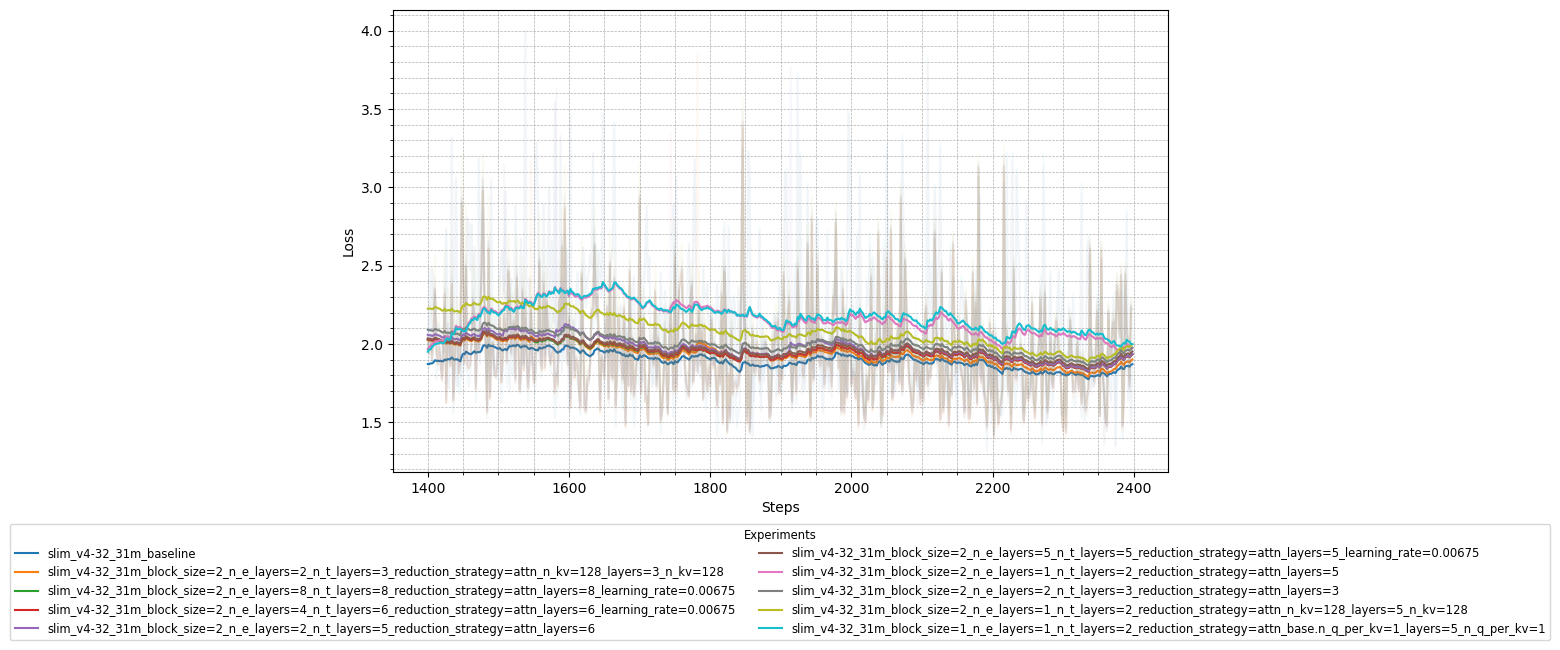

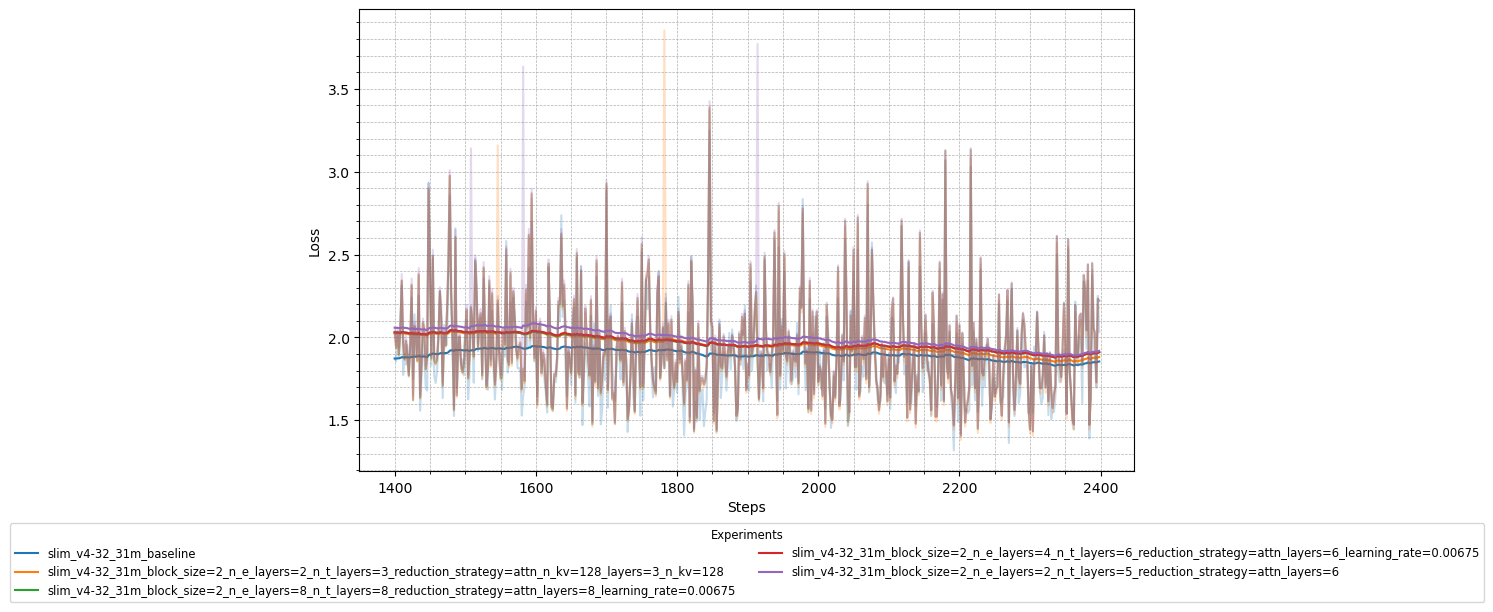

In [ ]:
# %%

plot_loss_data(metrics_data, plot_last=500, ema_smoothing=0.97, top_k=10, opacity=0.05)
plot_loss_data(metrics_data, plot_last=500, ema_smoothing=0.99, top_k=5)

In [ ]:
# %%

top_k_metrics_data = get_top_k_experiments(metrics_data, k=10, ema_smoothing=0.97)
get_eval_metrics_table(metrics_data, config_data)

,Name,Eval Loss,Block_Size,Concept_Decoder_Layers,Encoder_Layers,Token_Decoder_Layers,Reduction_Strategy,Attention_Heads,Query_Per_Key_Value,Learning_Rate
0,slim_v4-32_31m_baseline,1.849695,-,8,-,-,-,16,1,0.013500
1,slim_v4-32_31m_block_size...,1.874595,2,3,2,3,attn,128,1,0.013500
2,slim_v4-32_31m_block_size...,1.908515,2,8,8,8,attn,16,1,0.006750
3,slim_v4-32_31m_block_size...,1.908937,2,6,4,6,attn,16,1,0.006750
4,slim_v4-32_31m_block_size...,1.911174,2,6,2,5,attn,16,1,0.013500
5,slim_v4-32_31m_block_size...,1.927374,2,5,5,5,attn,16,1,0.006750
6,slim_v4-32_31m_block_size...,1.936809,2,3,3,3,attn,16,2,0.013500
7,slim_v4-32_31m_block_size...,1.949907,2,3,2,3,attn,16,1,0.013500
8,slim_v4-32_31m_block_size...,1.968789,2,5,1,2,attn,128,1,0.013500
9,slim_v4-32_31m_block_size...,1.985042,2,30,1,2,attn,16,1,0.020380
